# 1. Цель лабораторной работы


Изучить линейные модели, SVM и деревья решений

# 2. Задание

1.	Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2.	В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3.	С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4.	Обучите следующие модели:
  -	одну из линейных моделей;
  -	SVM;
  -	дерево решений.
5.	Оцените качество моделей с помощью трех подходящих для задачи метрик. Сравните качество полученных моделей.
6.	Произведите для каждой модели подбор одного гиперпараметра с использованием GridSearchCV и кросс-валидации.
7.	Повторите пункт 4 для найденных оптимальных значений гиперпараметров. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.


# 3. Ход выполнения работы

Подключим все необходимые библиотеки и настроим отображение графиков:

In [0]:
from google.colab import files

from datetime import datetime
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz, plot_tree

%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

In [4]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving covid19-russia-cases.csv to covid19-russia-cases.csv
User uploaded file "covid19-russia-cases.csv" with length 281785 bytes


## Предварительная подготовка данных

Датасет - COVID-19 Russia regions cases. COVID-19 virus (coronavirus) has been starting to spread inside of Russia. This is important to investigate and understand the spreading from a very low level. The world-level data is representing Russia virus cases as a single point. But Russia is a very huge and heterogeneous country. For better analyze we have to consider Russia infection cases distributed by region. So this is a dataset of regions distributed COVID-19 virus inside of Russia.

In [0]:
data = pd.read_csv("covid19-russia-cases.csv", delimiter=';')

Уберем столбец с названиями и реобразуем дату в соответствующий временной формат:

In [0]:
df = data.copy()

df["Date"] = pd.to_datetime(df["Date"]).astype(np.int64)/1000000

df = df.drop(["Region/City-Eng"], axis=1)

df["Region_ID"] =df["Region_ID"].fillna(method='ffill')

df=df.dropna()

Верхушка данных и типы

In [83]:
df.head()

,Date,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
1,1.580429e+12,72.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.580429e+12,75.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.606867e+12,72.0,0.0,0.0,1.0,1.0,0.0,1.0
4,1.606867e+12,75.0,0.0,0.0,1.0,1.0,0.0,1.0
5,1.583107e+12,50.0,1.0,0.0,0.0,1.0,0.0,0.0


In [84]:
df.dtypes

Date             float64
Region_ID        float64
Day-Confirmed    float64
Day-Deaths       float64
Day-Recovered    float64
Confirmed        float64
Deaths           float64
Recovered        float64
dtype: object

In [85]:
data.isnull().sum()

Date               0
Region/City-Eng    0
Region_ID          2
Day-Confirmed      0
Day-Deaths         0
Day-Recovered      0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

Проверим основные статистические характеристики набора данных:

In [86]:
df.describe()

,Date,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Deaths,Recovered
count,4.498000e+03,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000,4498.000000
mean,1.590025e+12,44.236105,80.616052,0.848155,29.179191,1654.563139,15.745220,352.179858
std,6.111935e+09,25.034676,393.074041,5.128834,214.880010,9997.870475,108.936064,2274.627093
min,1.578096e+12,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.587082e+12,23.000000,5.000000,0.000000,0.000000,57.000000,0.000000,7.000000
50%,1.588637e+12,44.000000,23.000000,0.000000,3.000000,309.500000,3.000000,46.000000
75%,1.590365e+12,65.000000,54.000000,0.000000,18.000000,966.000000,8.000000,243.000000
max,1.607126e+12,95.000000,6703.000000,77.000000,8033.000000,169303.000000,2110.000000,61619.000000


## Разделение данных

In [0]:
X = df.drop("Deaths", axis=1)
y = df["Deaths"]

In [88]:
print(X.head(), "\n")
print(y.unique()[1:20])

           Date  Region_ID  Day-Confirmed  ...  Day-Recovered  Confirmed  Recovered
1  1.580429e+12       72.0            1.0  ...            0.0        1.0        0.0
2  1.580429e+12       75.0            1.0  ...            0.0        1.0        0.0
3  1.606867e+12       72.0            0.0  ...            1.0        1.0        1.0
4  1.606867e+12       75.0            0.0  ...            1.0        1.0        1.0
5  1.583107e+12       50.0            1.0  ...            0.0        1.0        0.0

[5 rows x 7 columns] 

[ 2.  3.  8.  1. 11. 16. 19. 20. 27. 29. 31. 10. 38. 13.  4. 50. 58. 14.
 72.]


In [89]:
print(X.shape)
print(y.shape)

(4498, 7)
(4498,)


Предобработаем данные, чтобы методы работали лучше:

In [90]:
columns = X.columns
scaler = StandardScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X, columns=columns).describe()

,Date,Region_ID,Day-Confirmed,Day-Deaths,Day-Recovered,Confirmed,Recovered
count,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03,4.498000e+03
mean,-1.691459e-14,-1.419743e-16,1.330022e-16,3.543828e-15,-4.230350e-16,5.504218e-17,-2.970365e-16
std,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00,1.000111e+00
min,-1.951890e+00,-1.727241e+00,-2.051141e-01,-1.653883e-01,-1.358080e-01,-1.654099e-01,-1.548469e-01
25%,-4.815543e-01,-8.483619e-01,-1.923924e-01,-1.653883e-01,-1.358080e-01,-1.598081e-01,-1.517692e-01
50%,-2.270731e-01,-9.432165e-03,-1.465944e-01,-1.653883e-01,-1.218452e-01,-1.345499e-01,-1.346216e-01
75%,5.568388e-02,8.294976e-01,-6.772009e-02,-1.653883e-01,-5.203106e-02,-6.887864e-02,-4.800435e-02
max,2.798426e+00,2.027969e+00,1.684955e+01,1.484944e+01,3.725200e+01,1.677028e+01,2.693788e+01


Разделим выборку на тренировочную и тестовую:

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                            test_size=0.25, random_state=88888888)

In [92]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3373, 7)
(1125, 7)
(3373,)
(1125,)


## Обучение моделей

Напишем функцию, которая считает метрики построенной модели:

In [0]:
def test_model(model):
    print("mean_absolute_error:",
          mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:",
          median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:",
          r2_score(y_test, model.predict(X_test)))

### Линейная модель — Lasso

Попробуем метод Lasso с гиперпараметром  α=1 :

In [94]:
las_1 = Lasso(alpha=1.0)
las_1.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим метрики построенной модели:

In [95]:
test_model(las_1)

mean_absolute_error: 4.124133992528734
median_absolute_error: 2.131072673854133
r2_score: 0.9940000146439701


### SVM

Попробуем метод NuSVR с гиперпараметром  ν=0.5 :

In [96]:
nusvr_05 = NuSVR(nu=0.5, gamma='scale')
nusvr_05.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False)

Проверим метрики построенной модели:

In [97]:
test_model(nusvr_05)

mean_absolute_error: 10.855885650957921
median_absolute_error: 1.9703708705041336
r2_score: 0.04761199933257154


SVM показал худшие,чем Lasso результаты.

### Дерево решений

Попробуем дерево решений с неограниченной глубиной дерева:

In [98]:
dt_none = DecisionTreeRegressor(max_depth=None)
dt_none.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Проверим метрики построенной модели:

In [99]:
test_model(dt_none)

mean_absolute_error: 2.030222222222222
median_absolute_error: 0.0
r2_score: 0.9894207518861448


Древо решений показывает заметно лучшие результаты, чем предыдущие методы.

In [0]:
def stat_tree(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print("Всего узлов:", n_nodes)
    print("Листовых узлов:", sum(is_leaves))
    print("Глубина дерева:", max(node_depth))
    print("Минимальная глубина листьев дерева:", min(node_depth[is_leaves]))
    print("Средняя глубина листьев дерева:", node_depth[is_leaves].mean())

In [101]:
stat_tree(dt_none)

Всего узлов: 2489
Листовых узлов: 1245
Глубина дерева: 26
Минимальная глубина листьев дерева: 4
Средняя глубина листьев дерева: 15.49558232931727


## Подбор гиперпараметра K

### Линейная модель — Lasso

Введем список настраиваемых параметров:

In [126]:
param_range = np.arange(0.001, 3.001, 0.1)
tuned_parameters = [{'alpha': param_range}]
tuned_parameters

[{'alpha': array([1.000e-03, 1.010e-01, 2.010e-01, 3.010e-01, 4.010e-01, 5.010e-01,
         6.010e-01, 7.010e-01, 8.010e-01, 9.010e-01, 1.001e+00, 1.101e+00,
         1.201e+00, 1.301e+00, 1.401e+00, 1.501e+00, 1.601e+00, 1.701e+00,
         1.801e+00, 1.901e+00, 2.001e+00, 2.101e+00, 2.201e+00, 2.301e+00,
         2.401e+00, 2.501e+00, 2.601e+00, 2.701e+00, 2.801e+00, 2.901e+00])}]

Запустим подбор параметра:

In [127]:
gs = GridSearchCV(Lasso(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Проверим результаты при разных значения гиперпараметра на тренировочном наборе данных:

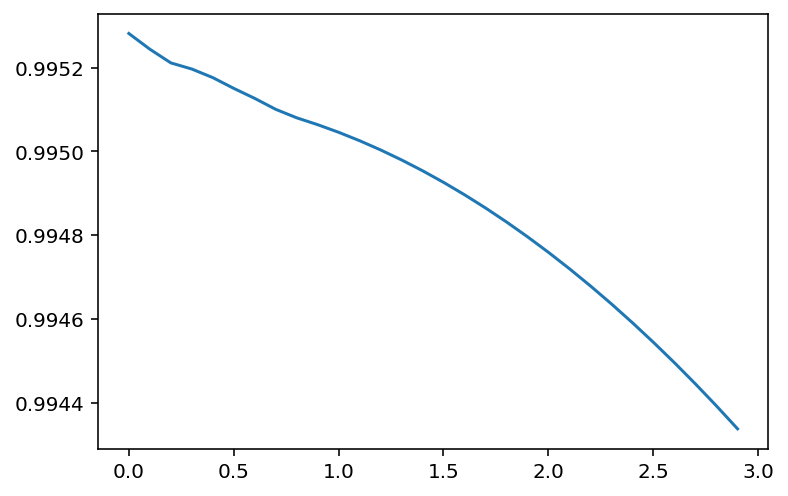

In [128]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод Lasso здесь не особо хорошо справляется.

На тестовом наборе данных:

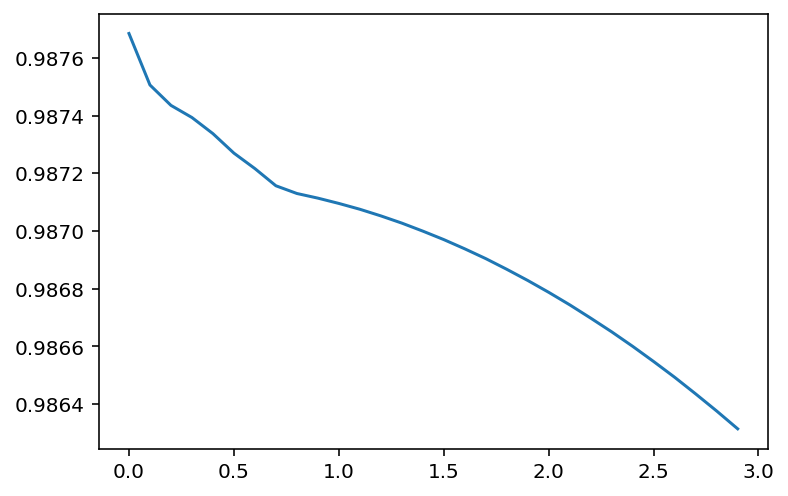

In [129]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Будем считать, что GridSearch показал, что нам нужна обычная линейная регрессия:

In [130]:
reg = LinearRegression()
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 4.177608974042815
median_absolute_error: 2.50487042054967
r2_score: 0.9931763334214286


Получили примерно тот же результат.

### SVM

Введем список настраиваемых параметров:

In [136]:
param_range = np.arange(0.01, 0.5, 0.1)
tuned_parameters = [{'nu': param_range}]
tuned_parameters

[{'nu': array([0.01, 0.11, 0.21, 0.31, 0.41])}]

Запустим подбор параметра:

In [138]:
gs = GridSearchCV(NuSVR(gamma='scale'), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.11, shrinking=True, tol=0.001, verbose=False)

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

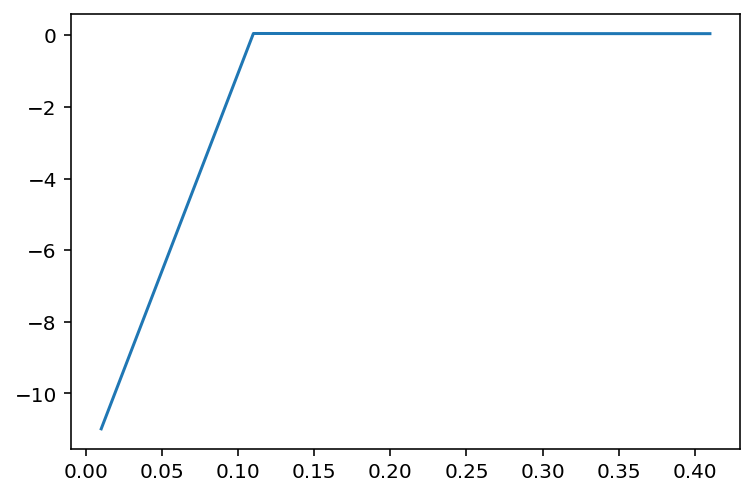

In [139]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Видно, что метод NuSVR справляется лучше, но не глобально. Получившееся оптимальное значение  ν=0,11.

На&nbsp;тестовом наборе данных картина ровно та же:

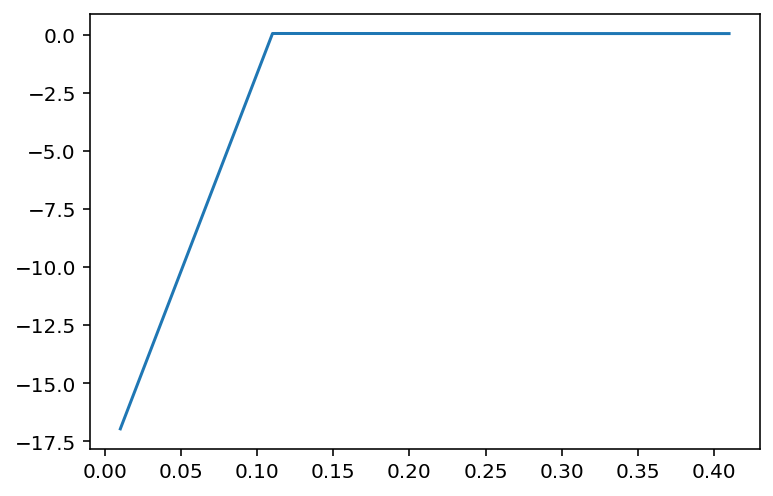

In [140]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проведем обучение с полученным оптимальным значением гиперпараметра.

In [151]:
nusvr_011 = NuSVR(nu=0.11, gamma='scale')
nusvr_011.fit(X_train, y_train)

NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.11, shrinking=True, tol=0.001, verbose=False)

In [152]:
test_model(nusvr_011)

mean_absolute_error: 14.005861498649539
median_absolute_error: 6.81731085777303
r2_score: 0.051029198076012916


Результаты хуже, чем со стандартным параметром.

### Дерево решений

Введем список настраиваемых параметров:

In [161]:
param_range = np.arange(1, 40, 2)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
         35, 37, 39])}]

Запустим подбор параметра:

In [163]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=25,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

Проверим результаты при&nbsp;разных значения гиперпараметра на&nbsp;тренировочном наборе данных:

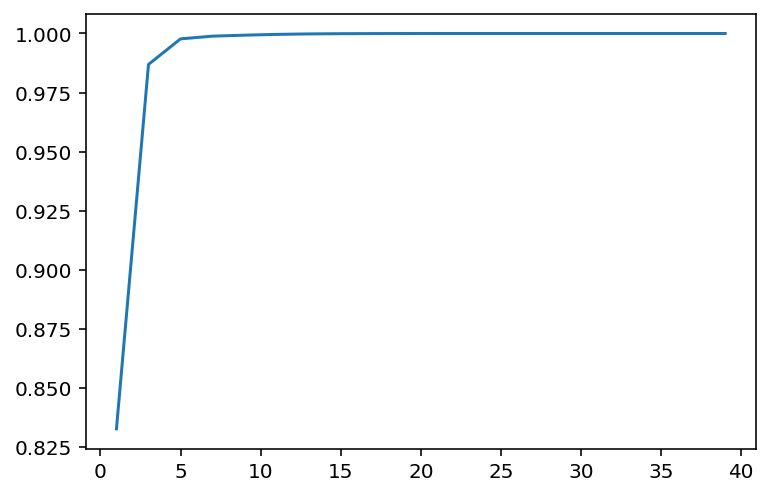

In [164]:
plt.plot(param_range, gs.cv_results_["mean_train_score"]);

Оптимальное значение параметра 25.

На тестовом наборе данных:

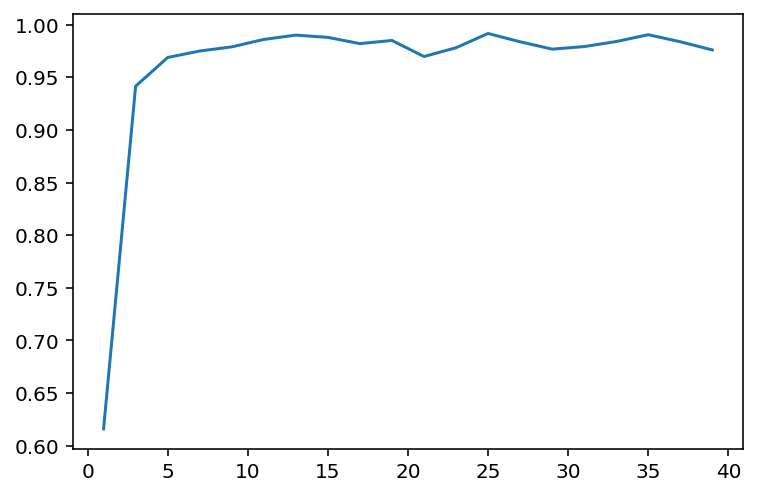

In [165]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Проведем дополнительное исследование в районе пика (25).

In [166]:
param_range = np.arange(21, 29, 1)
tuned_parameters = [{'max_depth': param_range}]
tuned_parameters

[{'max_depth': array([21, 22, 23, 24, 25, 26, 27, 28])}]

In [167]:
gs = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,
                  cv=ShuffleSplit(n_splits=10), scoring="r2",
                  return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_estimator_

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=24,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

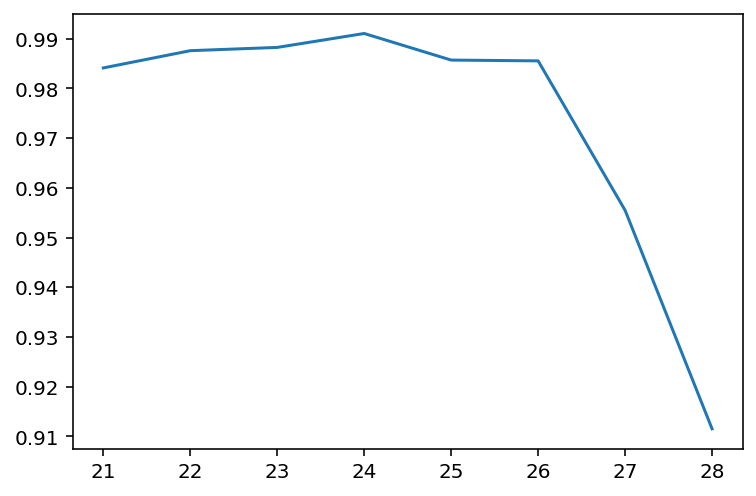

In [168]:
plt.plot(param_range, gs.cv_results_["mean_test_score"]);

Получили, что глубину дерева необходимо ограничить 24 уровнями. Проверим этот результат.

In [172]:
reg = gs.best_estimator_
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 1.9222433862433859
median_absolute_error: 0.0
r2_score: 0.9936984771100257


In [189]:
dt_24 = DecisionTreeRegressor(max_depth=24)
dt_24.fit(X_train, y_train)
test_model(dt_24)

mean_absolute_error: 1.8834285714285712
median_absolute_error: 0.0
r2_score: 0.9939023929380585


Вновь посмотрим статистику получившегося дерева решений.

In [173]:
stat_tree(reg)

Всего узлов: 2485
Листовых узлов: 1243
Глубина дерева: 24
Минимальная глубина листьев дерева: 4
Средняя глубина листьев дерева: 15.460981496379727


Получили незначительно улучшившийся результат.

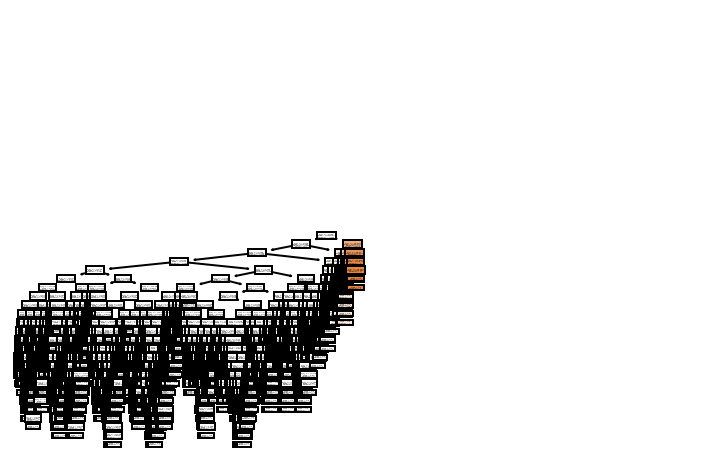

In [174]:
plot_tree(reg, filled=True);

In [175]:
dot_data = export_graphviz(reg, out_file=None, feature_names=columns,
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph

Видно, что сгенерировалось огромное множество различных условий. Древо решений не вполне подходит для конкретной задачи, но выдает приемлимые результаты.